In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import h5py
import time
import numpy as np
import argparse
import keras
import pandas as pd
import keras.backend as K
from keras.models import Model,model_from_json, load_model
from keras.layers import Input, Dropout, Dense, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split
#load dataset
file = '/hdd2/datasets/ESC50/output.h5'
f = h5py.File(file, 'r')

data = f.get('audioFrames')
data = np.array(data)
data = data.T
print(data.shape)
#labels = pd.read_hdf(file,'info').Label
#data = data.reshape(16642,44100,1)


df = pd.read_hdf('/hdd2/datasets/ESC50/output.h5','info')
labels = df['Label'].values
X_train, X_test, train_labels, test_labels, idx_train,idx_test = train_test_split(f['audioFrames'][()].T, labels,np.arange(len(labels)), test_size=0.20,random_state=42)
X = X_test.reshape(3329,44100,1)
y = keras.utils.np_utils.to_categorical(test_labels, num_classes=50)

(16642, 44100)


In [3]:
file = 'ESC50_best_model_41.h5'
model = load_model(file)
model_json = model.to_json()
with open("ESC50_best_model_41.json", "w") as json_file:
    json_file.write(model_json)
#model.summary()

In [4]:
#original eval accuracy - double precision weights
#model.summary()
# model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adadelta(lr=0.08, rho=0.95,decay=0.0001), metrics=['accuracy'])
# scores = model.evaluate(X, y, batch_size=32, verbose=1)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [63]:
from sklearn.metrics import confusion_matrix,classification_report, f1_score, accuracy_score
class_names = ('Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects', 'Sheep', 'Crow', 'Rain', 
	    'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 
	    'Toilet flush', 'Thunderstorm', 'Crying baby', 'Sneezing', 'Clapping', 'Breathing', 
	    'Coughing', 'Footsteps', 'Laughing', 'Brushing teeth', 'Snoring', 'Drinking', 
	    'Door knock', 'Mouse click', 'Keyboard typing', 'Door', 'Can opening', 
	    'Washing machine', 'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking', 'Helicopter', 
	    'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks', 'Hand saw')
y_probabilities = model.predict(X)
predicted_labels = y_probabilities.argmax(axis=1)
#print('BCE accuracy: {:04.2f}'.format(accuracy_score(test_labels, predicted_labels)))
#print(confusion_matrix(test_labels,predicted_labels))
print(classification_report(test_labels, predicted_labels, target_names=class_names))

                 precision    recall  f1-score   support

            Dog       0.70      0.83      0.76        60
        Rooster       0.67      0.30      0.41        54
            Pig       0.95      0.75      0.84        75
            Cow       0.78      0.52      0.62        54
           Frog       0.89      0.68      0.77        75
            Cat       0.59      0.42      0.49        72
            Hen       0.66      0.64      0.65        59
        Insects       0.45      0.35      0.39        78
          Sheep       0.86      0.23      0.37        82
           Crow       0.80      0.51      0.63        72
           Rain       0.49      0.79      0.60        78
      Sea waves       0.64      0.18      0.28        79
 Crackling fire       0.07      0.92      0.13        60
       Crickets       0.16      0.31      0.21        87
 Chirping birds       0.44      0.25      0.32        67
    Water drops       0.38      0.33      0.35        58
           Wind       0.77    

In [6]:
from collections import defaultdict

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data
metrics_dict = report2dict(classification_report(test_labels, predicted_labels, target_names=class_names))
precision_list_orig = []
f1_list_orig = []
for k,v in metrics_dict.items():
    for m,val in v.items():
        if m == 'f1-score':
            f1_list_orig.append(val)
        if m == 'precision':
            precision_list_orig.append(val)
print(precision_list_orig)

[0.7, 0.67, 0.95, 0.78, 0.89, 0.59, 0.66, 0.45, 0.86, 0.8, 0.49, 0.64, 0.07, 0.16, 0.44, 0.38, 0.77, 0.45, 0.91, 0.51, 0.66, 0.33, 0.89, 0.76, 0.91, 0.6, 0.89, 0.72, 0.29, 0.32, 0.86, 0.22, 0.7, 0.71, 0.16, 0.61, 0.78, 0.95, 0.85, 0.39, 0.53, 0.9, 0.88, 0.62, 0.71, 0.76, 0.68, 0.59, 0.78, 0.97, 0.66]


# visualize the rank of weight matrices

full rank of all matrices [64, 64, 64, 128, 128, 128, 256]
rank list [5, 64, 64, 128, 128, 128, 256]


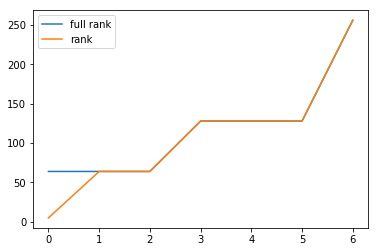

In [7]:
from reduction_utils import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

layers_list = ['conv1d_1', 'conv1d_2', 'conv1d_3', 'conv1d_4', 'conv1d_5', 'conv1d_6', 'conv1d_7', 'conv1d_8']
rank_list = []
full_rank_list = []
for idx,lay in enumerate(layers_list):
    if lay is not layers_list[-1]:
        op_layer = layers_list[idx]
        next_layer = layers_list[idx+1]
        weights_pack = extract_current_and_next_weights(model, op_layer, next_layer)
        wts, biases, next_wts, next_biases = weights_pack
        full_rank_list.append(wts.shape[2])
        wts = np.moveaxis(wts, 2, 0)
        wts = wts.reshape(wts.shape[0], -1)
        rank_list.append(np.linalg.matrix_rank(wts))
        
print("full rank of all matrices", full_rank_list)
print("rank list", rank_list)
plt.plot(range(len(full_rank_list)), full_rank_list, label = 'full rank')
plt.plot(range(len(full_rank_list)), rank_list, label = 'rank')
plt.legend(loc='upper left')
plt.show()

# Extract weights and make similarity matrix

(5, 128, 256) (256,) (5, 256, 266)
256


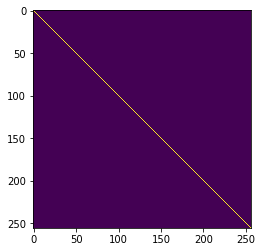

In [65]:
from reduction_utils import *
op_layer = 'conv1d_7'
next_layer = 'conv1d_8'

weights_pack = extract_current_and_next_weights(model, op_layer, next_layer)
wts, biases, next_wts, next_biases = weights_pack
print(wts.shape, biases.shape, next_wts.shape)

simil_thresh = 0.8
cc_list, adj_mat = get_conn_comp_direct(wts, simil_thresh)
print(len(cc_list))
plt.imshow(adj_mat)

# modify arch and reduce layer

In [52]:
print(wts.shape)
wts = np.moveaxis(wts, 2, 0)
print(wts.shape)

(5, 128, 256)
(256, 5, 128)


In [53]:
#caveat - moveaxis on wts

scaled_pack = scale_layers(wts, biases, next_wts)
wts_norm, b_norm, layer_next_scaled = scaled_pack
print(wts_norm.shape)
print(np.linalg.matrix_rank(wts_norm))
#if len(wts_norm.shape)<3:
    #layer_curr_weights = np.atleast_3d(wts_norm)
layer_curr_weights = wts_norm.reshape(wts.shape)
print(layer_curr_weights.shape)
print(layer_next_scaled.shape)

(256, 640)
256
(256, 5, 128)
(5, 256, 266)


In [54]:
reduced_pack = reduce_layers(layer_curr_weights, b_norm, layer_next_scaled, cc_list)
new_weights, new_biases, new_next_layer_weights = reduced_pack
print(new_weights.shape, new_biases.shape, new_next_layer_weights.shape)

new weight filter shape (242, 5, 128)
new bias shape (242,)
new next layer activations shape (242, 5, 266)
(242, 5, 128) (242,) (242, 5, 266)


# Altering model JSON

In [55]:
json_file = 'ESC50_best_model_41.json'
current_layer = op_layer
#next_layer = 'conv1d_2'
reduced_filters  = new_weights.shape[0]
new_json = modify_json(json_file, current_layer, next_layer, reduced_filters)
print(new_json)

modified_conv1d_7_ESC50_best_model_41.json


# reducing h5 file !!


In [56]:
model_params_file = "ESC50_best_model_41_copy.h5"
print('before reshape', new_weights.shape)
new_weights_reshaped = np.moveaxis(new_weights, 0, 2)
#new_weights_reshaped = np.moveaxis(new_weights_reshaped, 0, 1)
new_next_layer_weights_reshaped = np.moveaxis(new_next_layer_weights, 0, 1)

print('after reshape', new_weights_reshaped.shape)64, 64, 64, 128, 128, 128, 256
print(new_next_layer_weights_reshaped.shape)

modify_model_params(model_params_file, current_layer, next_layer, new_weights_reshaped, new_biases, new_next_layer_weights_reshaped, 0)

before reshape (242, 5, 128)
after reshape (5, 128, 242)
(5, 242, 266)
changing batchnorm for layer -->  7
changing batchnorm layers to size (242,)
modifying beta
modifying gamma
modifying moving_mean
modifying moving_variance


# double check new weight shapes

In [57]:
# import h5py
# f1 = h5py.File(model_params_file, 'r')
# print(len(list(f1['model_weights/batch_normalization_1/batch_normalization_1/beta:0'])))
# print("new conv1 shape",np.asarray(f1['model_weights/conv1d_1/conv1d_1/kernel:0']).shape)
# print("new conv2 shape",np.asarray(f1['model_weights/conv1d_2/conv1d_2/kernel:0']).shape)
# print("new conv3 shape",np.asarray(f1['model_weights/conv1d_3/conv1d_3/kernel:0']).shape)

64
new conv1 shape (5, 1, 64)
new conv2 shape (5, 64, 64)
new conv3 shape (5, 64, 64)


# Model eval - change layer names above to eval for different layer reductions

In [58]:
#load modified model from json
json_file = open(new_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
modified_net = model_from_json(loaded_model_json)
#modified_net.summary()
#load weights into model
modified_net.load_weights(model_params_file)
print("Loaded modified model from disk")
#modified_net.summary()

Loaded modified model from disk


In [59]:
modified_net.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adadelta(lr=0.08, rho=0.95,decay=0.0001), metrics=['accuracy'])
scores = modified_net.evaluate(X, y, batch_size=256, verbose=1)
print("%s: %.2f%%" % (modified_net.metrics_names[1], scores[1]*100))

3329/3329 [==============================] - 3s 807us/step
acc: 18.11%


In [60]:
from sklearn.metrics import confusion_matrix,classification_report, f1_score, accuracy_score
class_names = ('Dog', 'Rooster', 'Pig', 'Cow', 'Frog', 'Cat', 'Hen', 'Insects', 'Sheep', 'Crow', 'Rain', 
	    'Sea waves', 'Crackling fire', 'Crickets', 'Chirping birds', 'Water drops', 'Wind', 'Pouring water', 
	    'Toilet flush', 'Thunderstorm', 'Crying baby', 'Sneezing', 'Clapping', 'Breathing', 
	    'Coughing', 'Footsteps', 'Laughing', 'Brushing teeth', 'Snoring', 'Drinking', 
	    'Door knock', 'Mouse click', 'Keyboard typing', 'Door', 'Can opening', 
	    'Washing machine', 'Vacuum cleaner', 'Clock alarm', 'Clock tick', 'Glass breaking', 'Helicopter', 
	    'Chainsaw', 'Siren', 'Car horn', 'Engine', 'Train', 'Church bells', 'Airplane', 'Fireworks', 'Hand saw')
y_probabilities = modified_net.predict(X)
predicted_labels = y_probabilities.argmax(axis=1)
#print('BCE accuracy: {:04.2f}'.format(accuracy_score(test_labels, predicted_labels)))
#print(confusion_matrix(test_labels,predicted_labels))
print(classification_report(test_labels, predicted_labels, target_names=class_names))

BCE accuracy: 0.18
                 precision    recall  f1-score   support

            Dog       1.00      0.28      0.44        60
        Rooster       1.00      0.02      0.04        54
            Pig       1.00      0.20      0.33        75
            Cow       1.00      0.19      0.31        54
           Frog       0.89      0.21      0.34        75
            Cat       0.44      0.11      0.18        72
            Hen       0.73      0.32      0.45        59
        Insects       0.00      0.00      0.00        78
          Sheep       0.67      0.02      0.05        82
           Crow       1.00      0.18      0.31        72
           Rain       0.36      0.44      0.40        78
      Sea waves       1.00      0.01      0.02        79
 Crackling fire       0.00      0.00      0.00        60
       Crickets       0.13      0.41      0.20        87
 Chirping birds       0.00      0.00      0.00        67
    Water drops       1.00      0.02      0.03        58
           

/opt/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
from collections import defaultdict

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data
metrics_dict_mod = report2dict(classification_report(test_labels, predicted_labels, target_names=class_names))
precision_list_mod = []
f1_list_mod = []
for k,v in metrics_dict_mod.items():
    for m,val in v.items():
        if m == 'f1-score':
            f1_list_mod.append(val)
        if m == 'precision':
            precision_list_mod.append(val)
            
print(f1_list_mod)

[0.44, 0.04, 0.33, 0.31, 0.34, 0.18, 0.45, 0.0, 0.05, 0.31, 0.4, 0.02, 0.0, 0.2, 0.0, 0.03, 0.15, 0.06, 0.1, 0.0, 0.0, 0.0, 0.68, 0.1, 0.14, 0.19, 0.19, 0.18, 0.0, 0.04, 0.43, 0.0, 0.26, 0.08, 0.0, 0.16, 0.0, 0.28, 0.21, 0.24, 0.09, 0.03, 0.32, 0.1, 0.3, 0.29, 0.44, 0.0, 0.05, 0.37, 0.17]


/opt/anaconda/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1
23


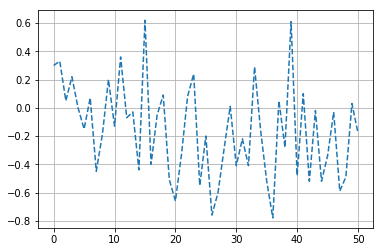

In [62]:
import matplotlib
import matplotlib.pyplot as plt

change_list_f1 = [x[1]-x[0] for x in zip(f1_list_orig, f1_list_mod)]
change_list_precision = [x[1]-x[0] for x in zip(precision_list_orig, precision_list_mod)]
prepos = 0
f1pos = 0
for elem in change_list_f1:
    if elem > -.1:
        f1pos += 1
print(f1pos)

for elem in change_list_precision:
    if elem > -.1:
        prepos += 1
print(prepos)

%matplotlib inline
plt.plot(range(len(change_list_precision)), change_list_precision, linestyle='--')
# plt.plot(range(len(precision_list_orig)), precision_list_orig, linestyle='--', label='org')
# plt.legend(loc='upper right')
# plt.plot(range(len(precision_list_mod)), precision_list_mod, linestyle='--', label='mod')
# plt.legend(loc='upper right')
plt.grid(True)
plt.show()